In [32]:
import numpy as np
from scipy.optimize import minimize


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [71]:
# gain utility function
def utility_gain(x, gamma_gain):
    return 1-np.exp(-gamma_gain*x)


# loss utility function
def utility_loss(x, gamma_loss):
    return -1 + np.exp(gamma_loss*x)

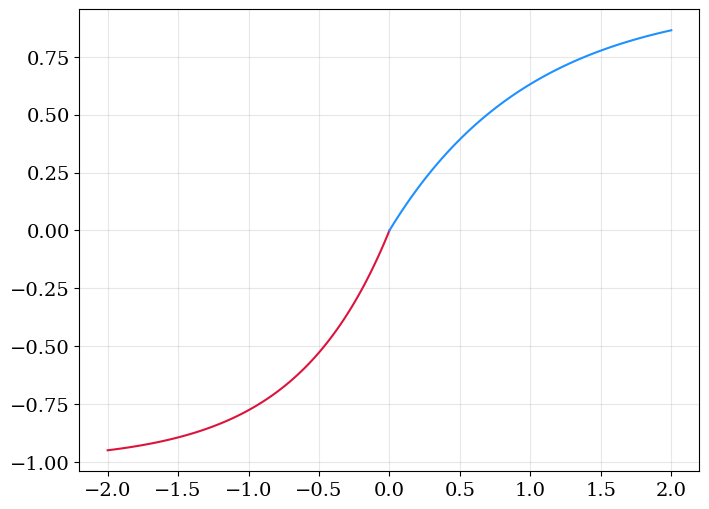

In [102]:
gamma_gain = 1.0
gamma_loss = 1.5

plt.plot(np.linspace(-2,0,100), utility_loss(np.linspace(-2,0,100), gamma_loss), color="crimson")
plt.plot(np.linspace(0,2,100), utility_gain(np.linspace(0,2,100), gamma_gain), color="dodgerblue")
plt.show()

In [106]:
# Define the expected gains and losses for the N risky assets
gains = np.array([1.465, 1.489, 1.088])
losses = np.array([-0.078, -0.087, -0.082])

# Define the probabilities of gains and losses for the N risky assets
gain_probabilities = np.array([0.793, 0.205, 0.226])

# Define the utility function
def utility(x):
    return np.where(x >= 0, utility_gain(x, gamma_gain), utility_loss(x, gamma_loss))

# Define the objective function to maximize the cumulative prospect utility
def objective(w):
    expected_utility = np.sum(gain_probabilities * utility(gains * w) + \
                              (1 - gain_probabilities) * utility(losses * w))
    return - expected_utility

# portfolio weights must sum to one
def constraint(w):
    return np.sum(w) - 1.0

cons = {'type': 'eq', 'fun': constraint}

# uniform initial weight vector
w0 = np.ones(gains.shape[0]) / gains.shape[0]

# bounds for weight vector
bounds = [(0.0, 1.0) for _ in range(gains.shape[0])]


result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
print('Optimal weight vector:', result.x.round(3))
print('Expected cumulative prospect utility:', -result.fun)

Optimal weight vector: [1. 0. 0.]
Expected cumulative prospect utility: 0.5868992877433032
